# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Data Science 2: Advanced Topics in Data Science 

## [Final Project] Social Media Toxicity Shield: Milestone 4


**Harvard University**<br/>
**Spring 2025**<br/>
**Team**: Amar Boparai, Andrew Lobo, Conrad Kaminski, Xiaoxuan Zhang, Xuanthe Nguyen<br/>
**Canvas Project Group**: 31

<hr style="height:2pt">

In [ ]:
# Library Imports
import os
import pickle
import re
import time
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from collections import Counter\

from tensorflow import keras
from keras.models import Model, Sequential, load_model
from keras import layers
from keras import losses
from keras import optimizers
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.callbacks import EarlyStopping, LambdaCallback, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.metrics import SparseCategoricalAccuracy, Precision, Recall, MeanIoU, AUC
from keras.layers import Input, Embedding, SimpleRNN, GRU, LSTM, TimeDistributed, Bidirectional, Dense
from keras.layers import  BatchNormalization, Activation, Dropout, GaussianNoise
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras import backend as K

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample
from sklearn.cluster import KMeans

# Issues with the below imports on my local machine—will likely resort to JupyterHub
import transformers
from transformers import BertTokenizer, TFBertForSequenceClassification, BertConfig
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, TFDebertaV2ForSequenceClassification
from transformers import TFBertPreTrainedModel, TFBertMainLayer

os.environ['TF_CPP_MIN_LOG_LEVEL']='2' # Trying to reduce tensorflow warnings
os.environ['TF_GPU_ALLOCATOR'] = "cuda_malloc_async"

<a id="contents"></a>
# Table of Contents
1. [**Problem Statement Refinement and Introduction**](#intro)
2. [**Comprehensive EDA Review**](#eda)
    - [**Key EDA Findings**](#find)
    - [**Initial Preprocessing**](#preprocess1)
    - [**Additional Preprocessing**](#preprocess2)
3. [**Modeling**](#model)
    - [**Baseline Model Choice**](#choice)
    - [**Training Process**](#train)
    - [**Initial Results**](#result)
4. [**Results Interpretation & Analysis**](#interp)
    - [**Analysis of Baseline Model Performance**](#analysis)
    - [**Proposed Improvements**](#improve)
5. [**Final Model Pipeline**](#final)
    - [**Assumptions, Parameter Choices, and Preliminary Tuning Considerations**](#assum)

<a id="intro"></a>

# 1. Problem Statement Refinement and Introduction

[Return to contents](#contents)

## Introduction
Online platforms vary widely in functionality and purpose, yet they all face a common problem: toxic content. Harmful posts can negatively impact users’ well-being—contributing to anxiety, depression, and other mental-health issues—and rely heavily on human moderators to keep forums safe. Although many platforms censor slurs or profanity, toxicity often goes beyond “bad words.” With today’s advanced tools, we have an opportunity to monitor—and mitigate—toxicity more effectively.

As a reminder, we’re using the Jigsaw Unintended Bias in Toxicity Classification dataset from [Kaggle](https://www.kaggle.com/datasets/julian3833/jigsaw-multilingual-toxic-comment-classification), which contains approximately 1.9 million comments labeled for various forms of toxicity.

## Problem Statement
- **Primary goal:** How can we reliably predict the toxicity of online comments?  
- **Secondary goals:** Which features contribute most to toxicity, and how can we assess our model’s fairness across different identity attributes?  
  In particular, many comments containing identity markers are labeled toxic more often than not—so we need to ensure our model can accurately detect toxicity regardless of such markers.

## Addressing Prior Feedback
Our earlier approach involved oversampling the minority (toxic) class, then applying a penalty to minority-class predictions—a contradictory strategy. We’ve removed that penalty to align sampling and loss functions.

## Adjusted Significance
Our earlier EDA reveals a severe class imbalance: non-toxic comments far outnumber toxic ones. To address this, we’ll optimize not only for overall accuracy but also for precision and recall—ensuring each class is identified correctly. We also take reassurance in knowing that toxic comments comprise only a small fraction of the dataset.


<a id="eda"></a>

# 2. Comprehensive EDA Review
[Return to contents](#contents)

<a id="find"></a>

## Key EDA Findings

[Return to contents](#contents)

- The most frequent words in toxic comments often have political connotations or express societal opinions (e.g., “people,” “state”). 
    - This doesn’t impact our feature engineering—just an interesting observation.  
- There is a significant class imbalance in the `toxic` class, as well as in most other variables (except `insult`):  
  - We combined the `severe_toxic` and `toxic` labels, since both capture the outcome we care about—whether a comment is toxic.  
  - To keep our training corpus robust, we will upsample toxic comments
  - When we have more time, we would also leverage a GPT-based generator to introduce more variety into the positive class.  
- The `insult` and `toxic` labels are highly correlated (0.75), while `toxic` shows only weak correlations with other predictors—another obvious but noteworthy point: toxicity often manifests as insults.  
- Most comments are under 250 characters, with frequency decaying exponentially until around 1,000 characters, where there’s a slight uptick (see image below). 
    - This pattern likely won’t affect feature extraction, but it may guide our choice of maximum sequence length for the tokenizer.

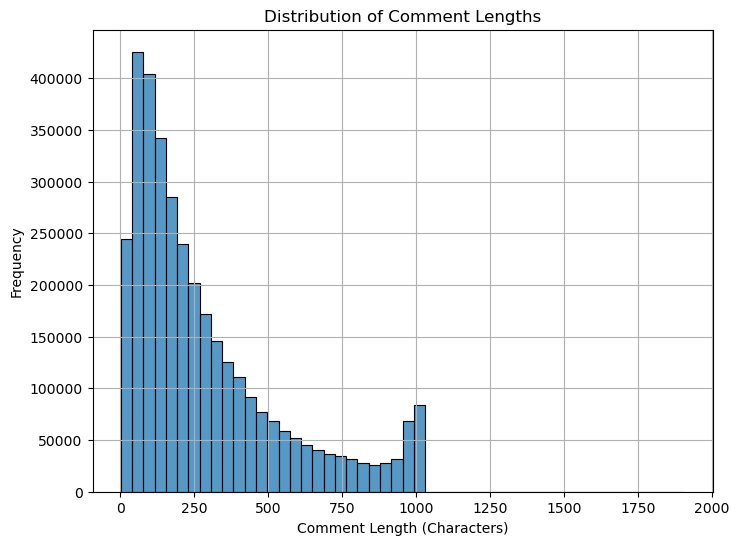

---

<a id="preprocess1"></a>

## Initial Preprocessing (MS2 & MS3)
[Return to contents](#contents)

1. [MS2] We only focused on the columns that provided an indication of toxicity, removing columns such as those related to identity or metadata. 
2. [MS2] After subsetting the data, less than 0.001% of the data was missing, so we dropped the missing data, as we deemed dropping it would be inconsequential.
3. [MS2] Feature scaling is not necessary for our classification task—the input is text and the output is binary.
4. [MS2/MS3] We noticed a massive class imbalance, so we decided to upsample the comments with the `toxic` class.
5. [MS3] We combined the `severe_toxic` and `toxic` class.

### 1. [MS2] We only focused on the columns that provided an indication of toxicity, removing columns such as those related to identity or metadata. 

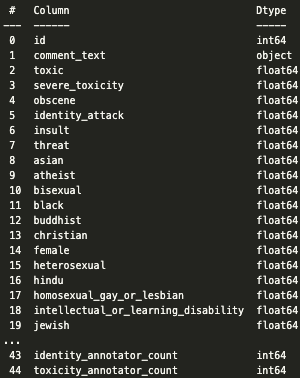

---

### 2. [MS2] After subsetting the data, less than 0.001% of the data was missing, so we dropped the missing data, as we deemed dropping it would be inconsequential.

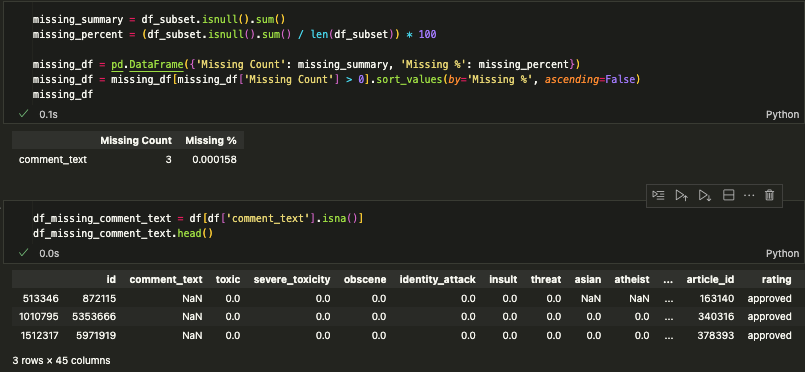

---

### 3. [MS2] Feature scaling is not necessary for our classification task—the input is text and the output is binary.

---

### 4. [MS2/MS3] We noticed a massive class imbalance, so we decided to upsample the comments with the `toxic` class.

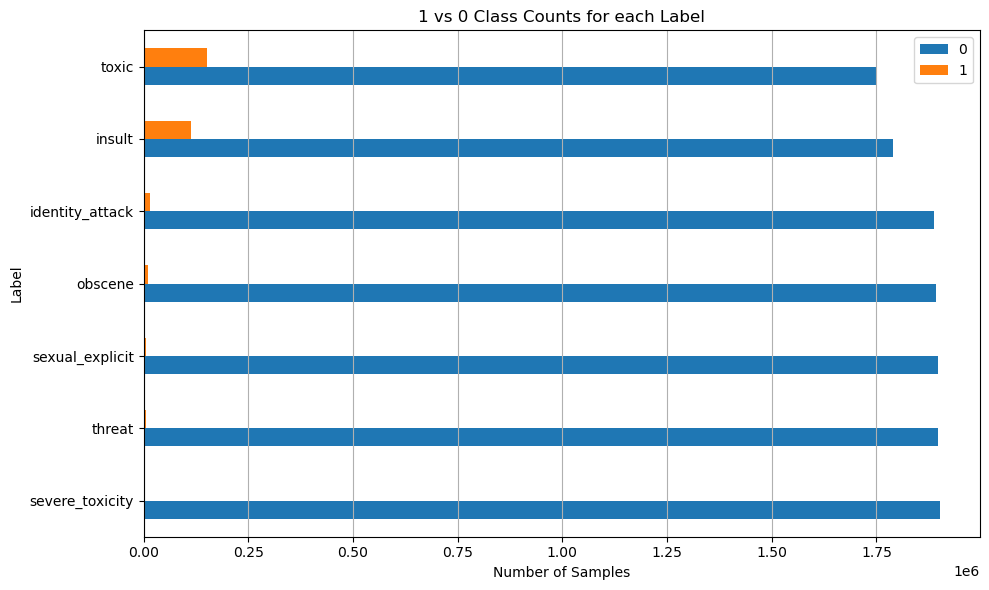

---

<a id="preprocess2"></a>

## Additional Preprocessing

[Return to contents](#contents)

##### We are going to start by combining the `severe_toxic` and `toxic` class

In [18]:
# Read the data
df = pd.read_csv("data/cleaned_ms2_data.csv")
df.head(3)

,id,comment_text,toxic,severe_toxicity,obscene,identity_attack,insult,threat,sexual_explicit
0,59848,"This is so cool. It's like, 'would you want yo...",0,0,0,0,0,0,0
1,59849,Thank you!! This would make my life a lot less...,0,0,0,0,0,0,0
2,59852,This is such an urgent design problem; kudos t...,0,0,0,0,0,0,0


In [19]:
# Combine toxic and severe_toxicity
df['toxic'] = df['toxic'] | df['severe_toxicity']
df = df.drop(columns=['severe_toxicity'])

# Hold out a stratified test set
X = df['comment_text']
y = df['toxic']
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

# Reconstruct train‐frame
train_df = pd.DataFrame({'comment_text': X_train, 'toxic': y_train})

---

##### Upsample the `toxic` class in training set

In [ ]:
# Separate toxic and non-toxic comments
tox = train_df[train_df.toxic == 1]
nontox = train_df[train_df.toxic == 0]

# Upsample the toxic class to match non-toxic size
tox_upsampled = resample(
    tox,
    replace=True,
    n_samples=len(nontox),
    random_state=109
)

train_balanced = pd.concat([nontox, tox_upsampled]).sample(frac=1, random_state=42)
train_balanced.toxic.value_counts()

toxic
0    1400063
1    1400063
Name: count, dtype: int64

##### The stage is now set for tokenization and to train the model!

<a id="model"></a>

# 3. Modeling
[Return to contents](#contents)

<a id="choice"></a>

## Baseline Model Choice
[Return to contents](#contents)

<a id="train"></a>

## Training Process
[Return to contents](#contents)

<a id="result"></a>

## Initial Results
[Return to contents](#contents)

<a id="interp"></a>

# 4. Results Interpretation & Analysis
[Return to contents](#contents)

<a id="analysis"></a>

## Analysis of Baseline Model Performance
[Return to contents](#contents)

<a id="improve"></a>

## Proposed Improvements
[Return to contents](#contents)

<a id="final"></a>

# 5. Final Model Pipeline
[Return to contents](#contents)

<a id="assum"></a>

## Assumptions, Parameter Choices, and Preliminary Tuning Considerations
[Return to contents](#contents)